In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Libraries**

In [ ]:
from google.colab import files
import os
import copy
import glob
import pandas as pd
import numpy as np
import warnings

import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import cv2

import keras
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from keras.layers import Flatten, Dense
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

from tensorflow.keras.applications import ResNet50V2, Xception
from keras.applications.mobilenet_v2 import MobileNetV2

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.utils import shuffle

# **Loading Images**

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255,validation_split=0.4)

train_data = train_gen.flow_from_directory("/content/drive/MyDrive/Monkeypox_dataset/train",target_size=(224,224),shuffle=True,class_mode='binary', batch_size=64)
valid_data = valid_gen.flow_from_directory('/content/drive/MyDrive/Monkeypox_dataset/val',target_size=(224,224),shuffle=True,class_mode='binary')

Found 2553 images belonging to 2 classes.
Found 639 images belonging to 2 classes.


# **Call Backs**

In [ ]:
checkpoint_filepath = '{epoch:02d}.h5'
checkpoint_dir = os.path.dirname(checkpoint_filepath)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

earlystop = EarlyStopping(monitor = 'val_accuracy', 
                          min_delta = 0, 
                          patience = 15,
                          verbose = 1,
                          mode='auto')

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.2,
                              patience = 4,
                              verbose = 1,
                              min_delta = 0.0001)

cb = [earlystop, reduce_lr, model_checkpoint_callback]

# **ResNet50V2**

In [ ]:
base_model_resnet = ResNet50V2(
      include_top=False,
      input_shape=(224,224,3))
base_model_resnet.trainable = False

model_resnet = Sequential([
      base_model_resnet,
      GlobalAveragePooling2D(),
      Dense(256,activation='relu'),
      BatchNormalization(),
      Dense(164,activation='relu'),
      BatchNormalization(),
      Dense(1,activation='sigmoid')])

model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 164)               42148     
                                                                 
 batch_normalization_5 (Batc  (None, 164)             

In [ ]:
model_resnet.compile(
      loss='binary_crossentropy',
      optimizer='rmsprop',
      metrics=['accuracy']
  )

cb_resenet = [EarlyStopping(patience=5,monitor='val_accuracy',mode='max',restore_best_weights=True),ModelCheckpoint("ResNet50.h5",save_best_only=True)]

In [ ]:
hist_resnet=model_resnet.fit(
      train_data,
      epochs=10,
      validation_data=valid_data,
      callbacks=cb_resenet
  )

Epoch 1/40
40/40 [==============================] - 48s 1s/step - loss: 0.2588 - accuracy: 0.8946 - val_loss: 0.2174 - val_accuracy: 0.9390
Epoch 2/40
40/40 [==============================] - 42s 1s/step - loss: 0.0765 - accuracy: 0.9777 - val_loss: 0.1567 - val_accuracy: 0.9577
Epoch 3/40
40/40 [==============================] - 42s 1s/step - loss: 0.0492 - accuracy: 0.9839 - val_loss: 0.1280 - val_accuracy: 0.9484
Epoch 4/40
40/40 [==============================] - 43s 1s/step - loss: 0.0322 - accuracy: 0.9914 - val_loss: 0.1153 - val_accuracy: 0.9562
Epoch 5/40
40/40 [==============================] - 43s 1s/step - loss: 0.0181 - accuracy: 0.9937 - val_loss: 0.0973 - val_accuracy: 0.9781
Epoch 6/40
40/40 [==============================] - 43s 1s/step - loss: 0.0241 - accuracy: 0.9918 - val_loss: 0.1308 - val_accuracy: 0.9656
Epoch 7/40
40/40 [==============================] - 43s 1s/step - loss: 0.0152 - accuracy: 0.9961 - val_loss: 0.1289 - val_accuracy: 0.9718
Epoch 8/40
40/40 [==

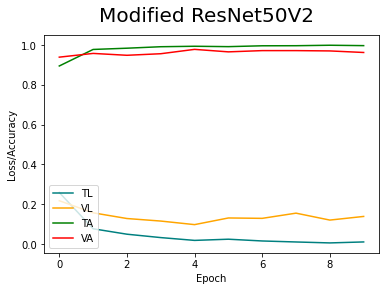

In [ ]:
fig = plt.figure()
plt.plot(hist_resnet.history['loss'], color='teal', label='TL')
plt.plot(hist_resnet.history['val_loss'], color='orange', label='VL')
plt.plot(hist_resnet.history['accuracy'], color='green', label='TA')
plt.plot(hist_resnet.history['val_accuracy'], color='red', label='VA')
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
fig.suptitle('ResNet50V2', fontsize=20)
plt.legend(loc="lower left")
plt.show()

# **MobileNetV2**

In [ ]:
base_model_mobilenet = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg')
base_model_mobilenet.trainable = False

model_mobilenet = Sequential([
      base_model_mobilenet,
      Dense(256,activation='relu'),
      Dropout(0.2),
      Dense(256,activation='relu'),
      Dropout(0.2),
      Dense(1,activation='sigmoid')])

model_mobilenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
model_mobilenet.compile(Adam(learning_rate=.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist_mobilenet=model_mobilenet.fit(
      train_data,
      epochs=40,
      validation_data=valid_data,
      callbacks=cb
  )

Epoch 1/40
40/40 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.7313
Epoch 1: val_accuracy improved from -inf to 0.83099, saving model to 01.h5
40/40 [==============================] - 172s 4s/step - loss: 0.5338 - accuracy: 0.7313 - val_loss: 0.3715 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 2/40
40/40 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.8758
Epoch 2: val_accuracy improved from 0.83099 to 0.92019, saving model to 02.h5
40/40 [==============================] - 167s 4s/step - loss: 0.2942 - accuracy: 0.8758 - val_loss: 0.2301 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 3/40
40/40 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.9177
Epoch 3: val_accuracy improved from 0.92019 to 0.94053, saving model to 03.h5
40/40 [==============================] - 165s 4s/step - loss: 0.1978 - accuracy: 0.9177 - val_loss: 0.1813 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 4/40
40/40 [==============================] - ETA: 0

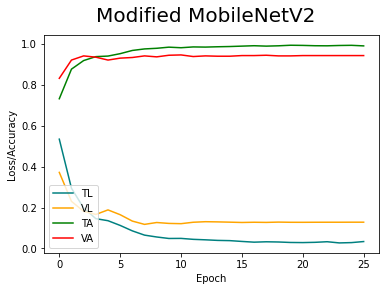

In [ ]:
fig = plt.figure()
plt.plot(hist_mobilenet.history['loss'], color='teal', label='TL')
plt.plot(hist_mobilenet.history['val_loss'], color='orange', label='VL')
plt.plot(hist_mobilenet.history['accuracy'], color='green', label='TA')
plt.plot(hist_mobilenet.history['val_accuracy'], color='red', label='VA')
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
fig.suptitle('MobileNetV2', fontsize=20)
plt.legend(loc="lower left")
plt.show()

In [ ]:
model_mobilenet.load_weights('11.h5')

In [ ]:
#For model json
model_json = model_mobilenet.to_json()
with open("model_monkeypox_mobilenet.json","w") as json_file:
     json_file.write(model_json)
files.download("model_monkeypox_mobilenet.json")

#For weights
model_mobilenet.save('weights_monkeypox_mobilenet.h5')
files.download('weights_monkeypox_mobilenet.h5')

In [ ]:
y_predicted_mobilenet = model_mobilenet.predict(valid_data) > 0.5
y_predicted_train_mobilenet = model_mobilenet.predict(train_data) > 0.5

20/20 [==============================] - 34s 2s/step


20/20 [==============================] - 34s 2s/step


Text(91.68, 0.5, 'Actual label')

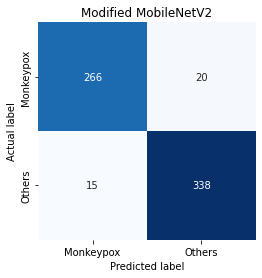

In [ ]:
mat = confusion_matrix(valid_data.classes, y_predicted_mobilenet)
labels = ['Monkeypox', 'Others']
ax = plt.axes()
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('MobileNetV2')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [ ]:
roc_auc_score(train_data.classes, y_predicted_train_mobilenet)

0.9884085636871169

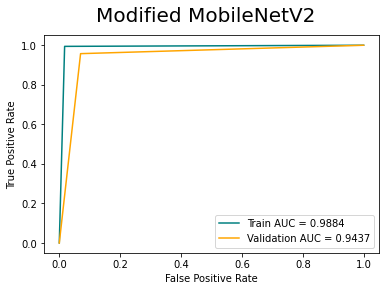

In [ ]:
fig = plt.figure()
fpr, tpr, thresholds = roc_curve(valid_data.classes, y_predicted_mobilenet)
fpr1, tpr1, thresholds1 = roc_curve(train_data.classes, y_predicted_train_mobilenet)
plt.plot(fpr1, tpr1, label='Train AUC = 0.9884', color='teal')
plt.plot(fpr, tpr, label='Validation AUC = 0.9437', color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
fig.suptitle('MobileNetV2', fontsize=20)
plt.legend(loc="lower right")

# **Xception**

In [ ]:
base_model_xception=Xception(
    include_top=False,
    input_shape=(224,224,3)
)
base_model_xception.trainable=False

model_xception = Sequential([
      base_model_xception,
      GlobalMaxPooling2D(),
      Dense(1024,activation='relu'),
      BatchNormalization(),
      Dense(1,activation='sigmoid')])

model_xception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_9 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 22,964,777
Trainable params: 2,101,249
N

In [ ]:
model_xception.compile(loss = 'binary_crossentropy', optimizer ='sgd', metrics= ['accuracy'])

In [ ]:
hist_xception=model_xception.fit(train_data, epochs = 20 , validation_data = valid_data,  callbacks=cb)

Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 0.4639 - accuracy: 0.7732 
Epoch 1: val_accuracy improved from -inf to 0.86385, saving model to 01.h5
40/40 [==============================] - 922s 22s/step - loss: 0.4639 - accuracy: 0.7732 - val_loss: 0.3968 - val_accuracy: 0.8638 - lr: 0.0100
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.9033 
Epoch 2: val_accuracy improved from 0.86385 to 0.89828, saving model to 02.h5
40/40 [==============================] - 852s 21s/step - loss: 0.2440 - accuracy: 0.9033 - val_loss: 0.3236 - val_accuracy: 0.8983 - lr: 0.0100
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.1787 - accuracy: 0.9432 
Epoch 3: val_accuracy improved from 0.89828 to 0.90297, saving model to 03.h5
40/40 [==============================] - 844s 21s/step - loss: 0.1787 - accuracy: 0.9432 - val_loss: 0.2851 - val_accuracy: 0.9030 - lr: 0.0100
Epoch 4/20
40/40 [==============================] - 

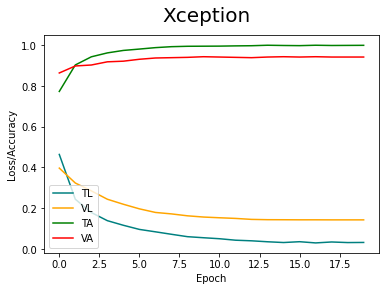

In [ ]:
fig = plt.figure()
plt.plot(hist_xception.history['loss'], color='teal', label='TL')
plt.plot(hist_xception.history['val_loss'], color='orange', label='VL')
plt.plot(hist_xception.history['accuracy'], color='green', label='TA')
plt.plot(hist_xception.history['val_accuracy'], color='red', label='VA')
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
fig.suptitle('Xception', fontsize=20)
plt.legend(loc="lower left")
plt.show()